**SIGNAL PREDICTION**

Let's first import the required libraries.

In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import os
from keras.layers import LSTM, Input, Activation, Dense, TimeDistributed
from keras.models import Sequential

Using TensorFlow backend.


Now import the data and display the information about it.

In [2]:
data_henon = pd.read_csv("../input/henon.csv", header=None)
data_lorenz = pd.read_csv("../input/lorenz.csv", header=None)
data_rossler = pd.read_csv("../input/rossler.csv", header=None)
data_henon.describe()

,0
count,16384.000000
mean,0.365823
std,1.005009
min,-1.798490
25%,-0.463950
50%,0.581744
75%,1.175150
max,1.782120


In [ ]:
data_lorenz.describe()

In [ ]:
data_rossler.describe()

**Choose the dataset used for the learning**

In [3]:
train_data = data_henon

Pre-process the data.
The given datasets represent continuous-time signals. This means that most of the values in the dataset are unique and never repeat, which makes learning very complicated. Thus, we discritize the signals before we start the learning phase.

In [4]:
print("Total number of data points: ", len(train_data[0]))
print("Number of unique data points: ", len(train_data[0].unique()))

Total number of data points:  16384
Number of unique data points:  16108


In [5]:
n_values = 100
train, bins = pd.cut(train_data[0], n_values, labels=False, retbins=True)
train.head()

0     9
1    45
2    76
3    63
4    91
Name: 0, dtype: int64

Convert all the data to corresponding one-hot vectors.

In [6]:
train_oh = pd.get_dummies(train)
train_oh.head()

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0


Since we cannot feed the pandas dataframe to Keras, first convert the data to a numpy array.

In [7]:
context_length = 3

data_np = train_oh.values[:-context_length,:]
print("Shape of the input data: ", data_np.shape)
y = train_oh.values[context_length:,:]
print("Shape of the ouput data: ", y.shape)

Shape of the input data:  (16381, 100)
Shape of the ouput data:  (16381, 100)


Prepare the RNN model in Keras.

In [8]:
def get_model(c):
    model = Sequential()
    model.add(LSTM(64, input_shape=(c,1), return_sequences=False))
    model.add(Dense(1))
    model.add(Activation("linear"))
    
    return model

We have to pre-process the input, so it is not a single number, but a sequence of the chosen length (context_length).

In [19]:
Tx, n_values = data_np.shape
train_np = train_data.values

context_length = 3
y_train = train_np[context_length:,:]
train_np_expanded = np.repeat(train_np[:,np.newaxis], context_length, 1)
for i in range(1,context_length):
    train_np_expanded[:-i,i,:] = train_np_expanded[i:,i,:]
x_train = train_np_expanded[:-context_length,:,:]

In [10]:
model = get_model(context_length)
model.compile(loss='mean_squared_error', optimizer='rmsprop', metrics=['mse']) 

In [11]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 64)                16896     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65        
_________________________________________________________________
activation_1 (Activation)    (None, 1)                 0         
Total params: 16,961
Trainable params: 16,961
Non-trainable params: 0
_________________________________________________________________


In [12]:
model.fit(x_train, y_train, epochs=20)

Epoch 1/20
16381/16381 [==============================] - 3s 201us/step - loss: 0.5309 - mean_squared_error: 0.5309
Epoch 2/20
16381/16381 [==============================] - 3s 179us/step - loss: 0.0109 - mean_squared_error: 0.0109
Epoch 3/20
16381/16381 [==============================] - 3s 180us/step - loss: 0.0030 - mean_squared_error: 0.0030
Epoch 4/20
16381/16381 [==============================] - 3s 183us/step - loss: 0.0022 - mean_squared_error: 0.0022
Epoch 5/20
16381/16381 [==============================] - 3s 181us/step - loss: 0.0018 - mean_squared_error: 0.0018
Epoch 6/20
16381/16381 [==============================] - 3s 183us/step - loss: 0.0015 - mean_squared_error: 0.0015
Epoch 7/20
16381/16381 [==============================] - 3s 179us/step - loss: 0.0013 - mean_squared_error: 0.0013
Epoch 8/20
16381/16381 [==============================] - 3s 180us/step - loss: 0.0011 - mean_squared_error: 0.0011
Epoch 9/20
16381/16381 [==============================] - 3s 179us/step 

Plot small part of the input data to see how it looks.

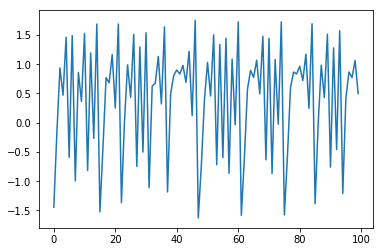

In [13]:
plt.plot(train_np[:100])

Get the signal by giving the real-data sequence and predicting the next value.

In [44]:
Ty = train_np.shape[0]
y_pred = list()
for y in range(Ty):
    example = np.reshape(train_np_expanded[y,:,:], (1,context_length,1))
    y_pred.append(model.predict(example).tolist()[0][0])

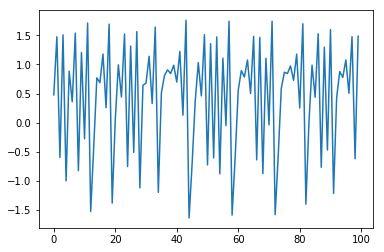

In [46]:
plt.plot(y_pred[:100])

In [57]:
Ty = train_np.shape[0]
y_pred = list()
example = np.reshape(train_np[:3], (1,context_length,1))
for y in range(Ty):
    prediction = model.predict(example).tolist()[0][0]
    for i in range(context_length-1):
        example[0][i] = example[0][i+1]
    example[0][2] = prediction
    y_pred.append(prediction)

(16384, 1)


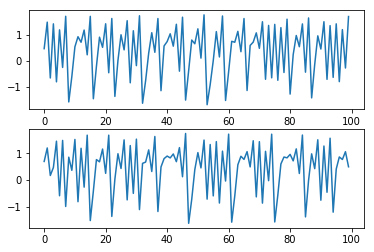

In [61]:
plt.subplot(2,1,1)
plt.plot(y_pred[:100])
plt.subplot(2,1,2)
plt.plot(train_np[:100])